# Laboratorium 4: Sieci Neuronowe i Keras/Tensorflow
## Część I. Sieci złożone

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

### Wczytywanie obrazów

In [2]:
import cv2
import os
import sklearn
image_size = tuple((64, 64))

def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            #image = preprocess_input(image)
            image = cv2.resize(image, image_size)
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('flower_photos')
print('loaded',len(samples),' samples')
print('classes',set(labels))

loaded 3670  samples
classes {'daisy', 'sunflowers', 'roses', 'tulips', 'dandelion'}


### Przykładowe obrazy

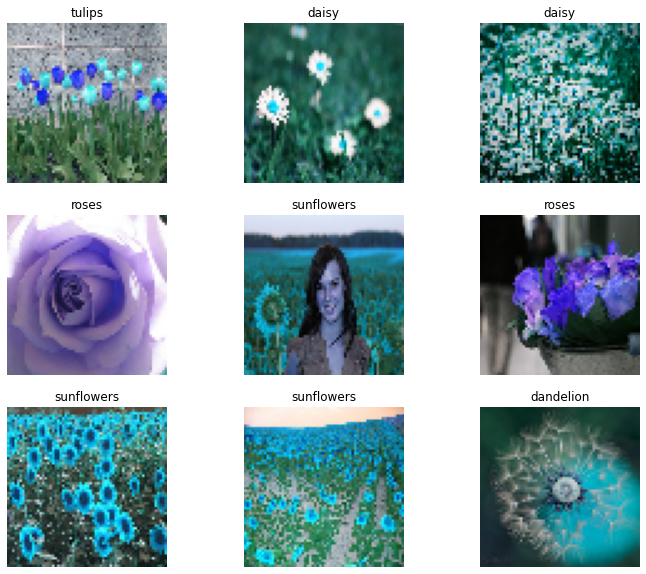

In [3]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    plt.title(labels[n])
    plt.axis("off")

### Ekstrakcja cech

In [4]:
import mahotas


# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

def fd_histogram(image, mask=None):
    bins=8
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    return hist.flatten()

### Flat Samples

In [5]:
new_samples = []
for i,image in enumerate(samples):
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    if(i%500==0): print(i,'/',len(samples))
    features = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    new_samples.append(features)
Flatsamples = np.array(new_samples)
print(Flatsamples.shape)

0 / 3670
500 / 3670
1000 / 3670
1500 / 3670
2000 / 3670
2500 / 3670
3000 / 3670
3500 / 3670
(3670, 532)


### One hot labels

In [6]:
# one-hot labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Labels shape",labels.shape)
labels = labels.astype(float)

Labels shape (3670, 5)


### Normalizacja

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
print(np.min(Flatsamples),np.max(Flatsamples))
Flatsamples = scaler.fit_transform(Flatsamples)
print(np.min(Flatsamples),np.max(Flatsamples))

-0.6241640388357443 42116.99917305573
0.0 1.0000000000000002


### Flat Model

In [8]:
dense_model = Sequential()
dense_model.add(Dense(250, input_dim=532, activation='relu'))
dense_model.add(Dense(250, activation='relu'))
dense_model.add(Dense(250, activation='sigmoid'))
dense_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               133250    
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
Total params: 258,750
Trainable params: 258,750
Non-trainable params: 0
_________________________________________________________________


### CNN

In [9]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=(64,64,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("sigmoid"))

### Łączenie Modeli

In [10]:
from tensorflow.keras.layers import concatenate
from tensorflow.python.keras.models import Model
combined = concatenate([model.output, dense_model.output])
combined = Dense(16, activation="sigmoid")(combined)
combined = Dense(5, activation="sigmoid")(combined)

combined_model = Model(inputs=[model.input, dense_model.input], outputs=combined)

print(combined_model.summary())


combined_model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         conv2d_input[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 16)   0           activation[0][0]                 
______________________________________________________________________________________________

### Trenowanie Modelu

In [11]:
EPOCHS = 40
BATCH= 120
combined_model.fit([samples,Flatsamples], labels, batch_size=BATCH, epochs=EPOCHS)

Epoch 1/40
31/31 [==============================] - 3s 86ms/step - loss: 1.6717 - accuracy: 0.2247
Epoch 2/40
31/31 [==============================] - 3s 88ms/step - loss: 1.5610 - accuracy: 0.3124
Epoch 3/40
31/31 [==============================] - 3s 91ms/step - loss: 1.3982 - accuracy: 0.4375
Epoch 4/40
31/31 [==============================] - 3s 89ms/step - loss: 1.2986 - accuracy: 0.4934
Epoch 5/40
31/31 [==============================] - 3s 88ms/step - loss: 1.2228 - accuracy: 0.5178
Epoch 6/40
31/31 [==============================] - 3s 88ms/step - loss: 1.1677 - accuracy: 0.5415
Epoch 7/40
31/31 [==============================] - 3s 88ms/step - loss: 1.1416 - accuracy: 0.5486
Epoch 8/40
31/31 [==============================] - 3s 86ms/step - loss: 1.0966 - accuracy: 0.5565
Epoch 9/40
31/31 [==============================] - 3s 92ms/step - loss: 1.0588 - accuracy: 0.5776
Epoch 10/40
31/31 [==============================] - 3s 92ms/step - loss: 1.0230 - accuracy: 0.6017
Epoch 11/

### Wyniki

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

results = combined_model.predict([samples,Flatsamples])
print(confusion_matrix(labels.argmax(axis=1), results.argmax(axis=1)))
print(classification_report(labels.argmax(axis=1), results.argmax(axis=1)))
print("Accuracy: {:.2f}".format(accuracy_score(labels.argmax(axis=1), results.argmax(axis=1))))
print("Cohen's Kappa {:.2f}".format(cohen_kappa_score(labels.argmax(axis=1), results.argmax(axis=1))))

[[610  12  11   0   0]
 [ 24 870   3   1   0]
 [ 29   5 596   1  10]
 [  0  34   1 651  13]
 [ 24   9 107   5 654]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       633
           1       0.94      0.97      0.95       898
           2       0.83      0.93      0.88       641
           3       0.99      0.93      0.96       699
           4       0.97      0.82      0.89       799

    accuracy                           0.92      3670
   macro avg       0.92      0.92      0.92      3670
weighted avg       0.93      0.92      0.92      3670

Accuracy: 0.92
Cohen's Kappa 0.90
